Ref: 
https://youtu.be/H6du_pfuznE 
https://github.com/krishnaik06/Stock-MArket-Forecasting

In [1]:
### Keras and Tensorflow >2.0
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
df = yf.download("TSLA")
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [2]:
df1=df.reset_index()['Close']

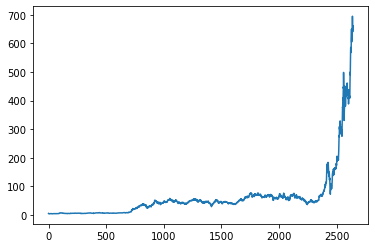

In [3]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [4]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler
import numpy as np
df1.tail(3)

2640    640.340027
2641    645.979980
2642    661.770020
Name: Close, dtype: float64

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
print(df1[:3])

[[0.00233869]
 [0.00232135]
 [0.00178076]]


In [6]:

##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]


In [7]:
training_size,test_size


(1717, 926)

In [8]:
train_data[:5]

array([[2.33869073e-03],
       [2.32134555e-03],
       [1.78075872e-03],
       [9.82885968e-04],
       [8.96158040e-05]])

In [9]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [10]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [11]:
print(X_train.shape), print(y_train.shape)

(1616, 100)
(1616,)


(None, None)

In [12]:
print(X_test.shape), print(ytest.shape)

(825, 100)
(825,)


(None, None)

In [13]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [14]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM


In [15]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


In [16]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)


Epoch 1/100
26/26 [==============================] - 6s 125ms/step - loss: 7.7132e-04 - val_loss: 0.0018
Epoch 2/100
26/26 [==============================] - 2s 89ms/step - loss: 3.6584e-05 - val_loss: 0.0027
Epoch 3/100
26/26 [==============================] - 2s 89ms/step - loss: 1.7886e-05 - val_loss: 0.0030
Epoch 4/100
26/26 [==============================] - 2s 88ms/step - loss: 1.8459e-05 - val_loss: 0.0032
Epoch 5/100
26/26 [==============================] - 2s 89ms/step - loss: 1.5038e-05 - val_loss: 0.0031
Epoch 6/100
26/26 [==============================] - 2s 91ms/step - loss: 1.4703e-05 - val_loss: 0.0033
Epoch 7/100
26/26 [==============================] - 2s 89ms/step - loss: 1.5287e-05 - val_loss: 0.0027
Epoch 8/100
26/26 [==============================] - 2s 88ms/step - loss: 1.3690e-05 - val_loss: 0.0029
Epoch 9/100
26/26 [==============================] - 2s 87ms/step - loss: 1.4235e-05 - val_loss: 0.0030
Epoch 10/100
26/26 [==============================] - 2s 88ms/s

In [18]:
import tensorflow as tf


In [19]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [20]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [21]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

34.655534728238

In [22]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))


142.6666922850874

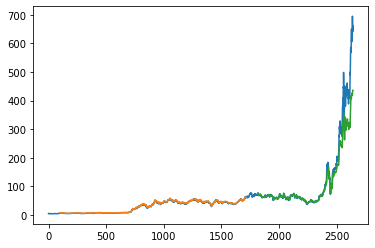

In [23]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


In [24]:
len(test_data)


926

In [25]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 585)

In [26]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()


In [27]:
temp_input[:3]

[0.08306834093058274, 0.08263760501515384, 0.07896334533486664]

In [42]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

0 day input [0.07047583 0.07539026 0.07399977 0.07172468 0.07059436 0.07086898
 0.08046369 0.07883326 0.08645352 0.09109043 0.09223231 0.09080135
 0.09294634 0.09495838 0.09557412 0.09412581 0.09402752 0.09608002
 0.09701665 0.09675936 0.09120027 0.09335396 0.09487743 0.09616097
 0.09785789 0.09761506 0.09588633 0.09319785 0.08962477 0.09545559
 0.0948543  0.09599618 0.09405932 0.09675069 0.09906626 0.09941605
 0.10038737 0.09891594 0.10099156 0.10145698 0.10141073 0.1043565
 0.10115344 0.09615518 0.09286251 0.09168883 0.08660384 0.08787292
 0.08082504 0.08969993 0.08682065 0.09194901 0.09163968 0.08508325
 0.08226179 0.08727162 0.0922641  0.09237685 0.09329614 0.09515784
 0.09581985 0.09210222 0.09500174 0.09547005 0.09583429 0.08281105
 0.08184551 0.07857019 0.0797034  0.08130204 0.08111124 0.08142345
 0.08469299 0.08418709 0.08568744 0.08588402 0.08832967 0.08713575
 0.08432874 0.08383441 0.08586957 0.08557181 0.08451954 0.08324757
 0.08443571 0.08378816 0.08289778 0.07962245 0.0806

ValueError: cannot reshape array of size 584 into shape (1,100,1)

In [43]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [44]:
len(df1)


2643

ValueError: x and y must have same first dimension, but have shapes (100,) and (1485, 1)

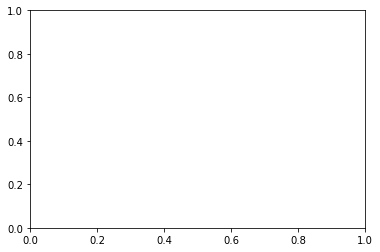

In [45]:
plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

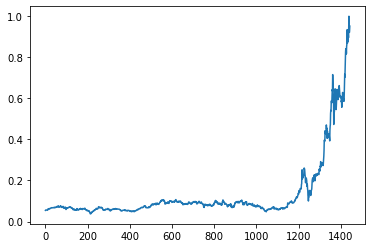

In [46]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [47]:
df3=scaler.inverse_transform(df3).tolist()

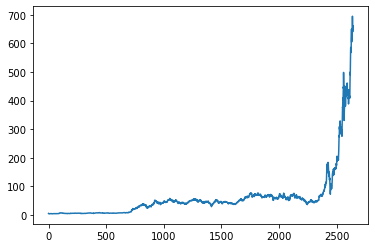

In [48]:
plt.plot(df3)